In [1]:
# datasets from my GitHub
!git clone https://github.com/William-HTP/Google-Play-App-Reviews-Datasets.git

Cloning into 'Google-Play-App-Reviews-Datasets'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), 3.18 MiB | 13.19 MiB/s, done.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import math
import time
import datetime

from matplotlib import pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [4]:
# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    DEVICE = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [115]:
# dataframe
df = pd.read_excel('/content/Google-Play-App-Reviews-Datasets/dataset_balanced_8000.xlsx')
pd.set_option('display.max_colwidth', None)
df

,ID,review,label,new_label,remove_all_stopwords,remove_some_stopwords,stemming,lemmatization
0,1,Not able to add freinds. It show something went wrong.. Recommend not to install it,bug report,0,able add freinds show something went wrong recommend install,not able add freinds show something went wrong recommend not install,not abl to add freind it show someth went wrong recommend not to instal it,not able to add freinds it show something went wrong recommend not to install it
1,2,Calls keep dropping for no reason and is super annoying,bug report,0,calls keep dropping reason super annoying,calls keep dropping no reason super annoying,call keep drop for no reason and is super annoy,call keep dropping for no reason and is super annoying
2,3,Can't access to my account solve this issue immediately,bug report,0,cant access account solve issue immediately,cant access account solve issue immediately,cant access to my account solv thi issu immedi,cant access to my account solve this issue immediately
3,4,"I don't know what's wrong with my own WhatsApp. Its not working. And if I want to sign up, it will just be bringing try again later. You guys should see to it.",bug report,0,dont know whats wrong whatsapp working want sign bringing try later guys see,dont know whats wrong whatsapp not working want sign up will bringing try again later guys should see,i dont know what wrong with my own whatsapp it not work and if i want to sign up it will just be bring tri again later you guy should see to it,i dont know whats wrong with my own whatsapp it not working and if i want to sign up it will just be bringing try again later you guy should see to it
4,5,Cannot record audio while taking video,bug report,0,cannot record audio taking video,cannot record audio taking video,cannot record audio while take video,cannot record audio while taking video
...,...,...,...,...,...,...,...,...
7995,7996,"good app, l will give you 5 star!",rating,2,good app l give 5 star,good app l will give 5 star,good app l will give you 5 star,good app l will give you 5 star
7996,7997,Never had a problem with it.,rating,2,never problem,never problem,never had a problem with it,never had a problem with it
7997,7998,It s great and I recommend it all the time to others.,rating,2,great recommend time others,great recommend all time others,it s great and i recommend it all the time to other,it s great and i recommend it all the time to others
7998,7999,"Everyone can use this app ,",rating,2,everyone use app,everyone can use app,everyon can use thi app,everyone can use this app


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     8000 non-null   int64 
 1   review                 8000 non-null   object
 2   label                  8000 non-null   object
 3   new_label              8000 non-null   int64 
 4   remove_all_stopwords   8000 non-null   object
 5   remove_some_stopwords  8000 non-null   object
 6   stemming               8000 non-null   object
 7   lemmatization          8000 non-null   object
dtypes: int64(2), object(6)
memory usage: 500.1+ KB


In [117]:
df['label'].value_counts()

bug report         2000
feature request    2000
rating             2000
user experience    2000
Name: label, dtype: int64

In [118]:
df = pd.DataFrame(df, columns = ["review", "new_label"])
df

,review,new_label
0,Not able to add freinds. It show something went wrong.. Recommend not to install it,0
1,Calls keep dropping for no reason and is super annoying,0
2,Can't access to my account solve this issue immediately,0
3,"I don't know what's wrong with my own WhatsApp. Its not working. And if I want to sign up, it will just be bringing try again later. You guys should see to it.",0
4,Cannot record audio while taking video,0
...,...,...
7995,"good app, l will give you 5 star!",2
7996,Never had a problem with it.,2
7997,It s great and I recommend it all the time to others.,2
7998,"Everyone can use this app ,",2


In [119]:
# Loading BERT base model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", #Using BERT base model with an uncased vocab.
                                                                num_labels = 4, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                            )
#BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()

print('Base models loaded') 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Base models loaded


In [120]:
# Split data into training and test sets
train_df, test_df = train_test_split(df, test_size = 0.2, random_state=42)

# Split training data into training and validation sets
test_df, valid_df = train_test_split(test_df, test_size = 0.5, random_state=42)

In [121]:
train_df['new_label'].value_counts()

3    1629
2    1600
0    1597
1    1574
Name: new_label, dtype: int64

In [122]:
valid_df['new_label'].value_counts()

0    220
1    210
3    189
2    181
Name: new_label, dtype: int64

In [123]:
test_df['new_label'].value_counts()

2    219
1    216
0    183
3    182
Name: new_label, dtype: int64

In [124]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def tokenization(dataset):
    sentences = dataset["review"].values
    labels = dataset["new_label"].values
    max_length = 256

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    bert_input_ids = []
    bert_attention_masks = []

    sentence_ids = []
    counter = 0

    # For every sentence...
    for sent in sentences:
        #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids
        bert_encoded_dict = bert_tokenizer.encode_plus(
                            str(sent),        #sentence              
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                            max_length = 256,     #Since we have seen from our analysis that majority of sentences have length less than 300.    
                            pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                            return_attention_mask = True,   # Create attention mask
                            truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                            return_tensors = 'pt',     # Return pytorch tensors.
                        )

      
        # Add the encoded sentence to the list.    
        bert_input_ids.append(bert_encoded_dict['input_ids'])
        
        # Add attention mask to the list 
        bert_attention_masks.append(bert_encoded_dict['attention_mask'])
      
        # collecting sentence_ids
        sentence_ids.append(counter)
        counter  = counter + 1
      
    # Convert the lists into tensors.
    bert_input_ids = torch.cat(bert_input_ids, dim=0)
    bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

    labels = torch.tensor(labels)
    sentence_ids = torch.tensor(sentence_ids)

    return bert_input_ids, bert_attention_masks, labels

In [55]:
def dataloader(input_ids, input_masks, labels):
    BATCH_SIZE = 16

    # Combine the training inputs into a TensorDataset.
    bert_train_dataset = TensorDataset(input_ids, input_masks, labels) 


    # Create the DataLoaders for our training - Loads the data randomly in batches of size 32
    dataloader = DataLoader(
                bert_train_dataset,  # The training samples.
                sampler = RandomSampler(bert_train_dataset), # Select batches randomly
                batch_size = BATCH_SIZE # Trains with this batch size.
            )

    return dataloader

In [56]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [57]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [58]:
def train(model, train_loader, valid_loader, device, epochs):

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    loss_values = []
    acc_values = []
    eval_loss_values = []
    eval_acc_values = []

    # optimizers - AdamW
    # here, i have used default learning rate and epsilon values for both BERT and RoBERTa
    bert_optimizer = AdamW(bert_model.parameters(),
                    lr = 5e-5, 
                    eps = 1e-8 
                    )


    # Total number of training steps is [number of batches] x [number of epochs]
    total_steps = len(train_loader) * epochs

    # Create the learning rate scheduler.
    bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                num_warmup_steps = 0, 
                                                num_training_steps = total_steps)


    best_acc = 0.0
    criterion = nn.CrossEntropyLoss()

    for epoch_i in range(epochs):
        #Training 
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_loss = 0
        train_accuracy = 0
        bert_model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_loader):
        #Report progress after every 40 epochs
            if step % 50 == 0 and not step == 0: 
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # print current training batch and elapsed time
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            bert_model.zero_grad()        
            
            outputs = bert_model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            # model returns a tuple, extract loss value from that tuple
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()

            logits = outputs[1]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_train_accuracy = flat_accuracy(logits, label_ids)
            train_accuracy += tmp_train_accuracy

            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
            bert_optimizer.step()
            bert_scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_loader) 
        loss_values.append(avg_train_loss) 
        train_acc = train_accuracy / len(train_loader) 
        acc_values.append(train_acc)          
        
        # Store the loss value for plotting the learning curve.
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        # ===================================
        #             Validation
        # ===================================
        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        eval_loss, eval_accuracy = 0, 0
        e_loss = 0

        for batch in valid_dataloader:

            batch = tuple(t.to(DEVICE) for t in batch)

            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
                loss = outputs[0]
                e_loss += loss.item()

                logits = outputs[1]
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                tmp_eval_accuracy = flat_accuracy(logits, label_ids)
                eval_accuracy += tmp_eval_accuracy

                eval_loss = total_loss / len(valid_dataloader)
        eval_loss_values.append(eval_loss)
        eval_acc = eval_accuracy / len(valid_dataloader)
        eval_acc_values.append(eval_acc)

        print("   Validation loss : {0:.5f}".format(eval_loss))
        print("   Validation acc  : {0:.5f}".format(eval_acc))
        print("   Validation took : {:}".format(format_time(time.time() - t0)))

    print("Training complete!")

    return loss_values, acc_values, eval_loss_values, eval_acc_values

In [125]:
train_input_ids, train_attention_masks, train_labels = tokenization(train_df)
valid_input_ids, valid_attention_masks, valid_labels = tokenization(valid_df)
test_input_ids, test_attention_masks, test_labels = tokenization(test_df)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [126]:
train_dataloader = dataloader(train_input_ids, train_attention_masks, train_labels)
valid_dataloader = dataloader(valid_input_ids, valid_attention_masks, valid_labels)
test_dataloader = dataloader(test_input_ids, test_attention_masks, test_labels)

In [127]:
EPOCHS = 5

loss_values, acc_values, eval_loss_values, eval_acc_values = train(bert_model, train_dataloader, valid_dataloader, DEVICE, EPOCHS)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 5 ========
Training...
  Batch    50  of    400.    Elapsed: 0:00:32.
  Batch   100  of    400.    Elapsed: 0:01:03.
  Batch   150  of    400.    Elapsed: 0:01:34.
  Batch   200  of    400.    Elapsed: 0:02:06.
  Batch   250  of    400.    Elapsed: 0:02:37.
  Batch   300  of    400.    Elapsed: 0:03:09.
  Batch   350  of    400.    Elapsed: 0:03:40.

  Average training loss: 0.75
  Training epcoh took: 0:04:12

Running Validation...
   Validation loss : 5.98805
   Validation acc  : 0.80500
   Validation took : 0:00:11

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    400.    Elapsed: 0:00:31.
  Batch   100  of    400.    Elapsed: 0:01:03.
  Batch   150  of    400.    Elapsed: 0:01:34.
  Batch   200  of    400.    Elapsed: 0:02:06.
  Batch   250  of    400.    Elapsed: 0:02:37.
  Batch   300  of    400.    Elapsed: 0:03:08.
  Batch   350  of    400.    Elapsed: 0:03:40.

  Average training loss: 0.29
  Training epcoh took: 0:04:11

Running Validation...

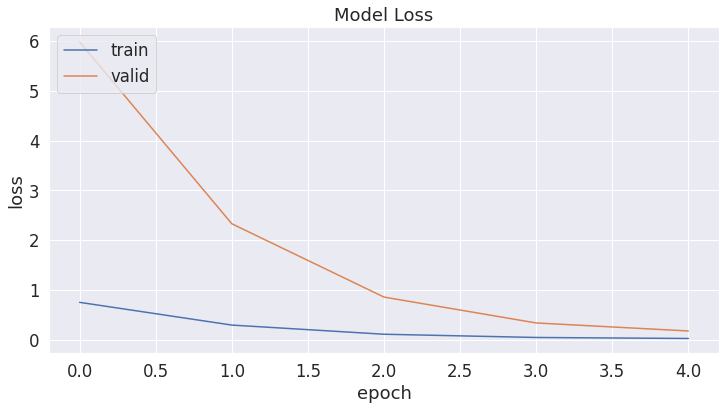

In [128]:
import seaborn as sns

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values)
plt.plot(eval_loss_values)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

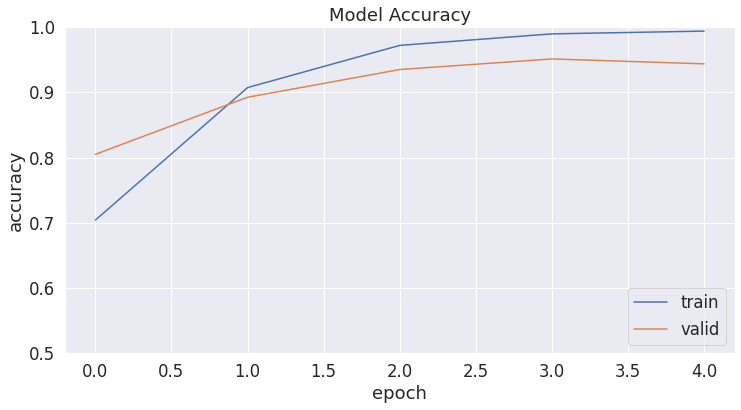

In [129]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(acc_values)
plt.plot(eval_acc_values)
plt.title('Model Accuracy')
plt.ylim(0.5, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [130]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(DEVICE) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = bert_model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
print('DONE.')

Predicting labels for 800 test sentences...
DONE.


In [131]:
from sklearn.metrics import classification_report, confusion_matrix

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

predictions_labels = [item for subitem in predictions for item in subitem]
predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

print(classification_report(predictions_labels, flat_true_labels))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       183
           1       0.92      0.96      0.94       208
           2       0.91      0.93      0.92       215
           3       0.92      0.87      0.89       194

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



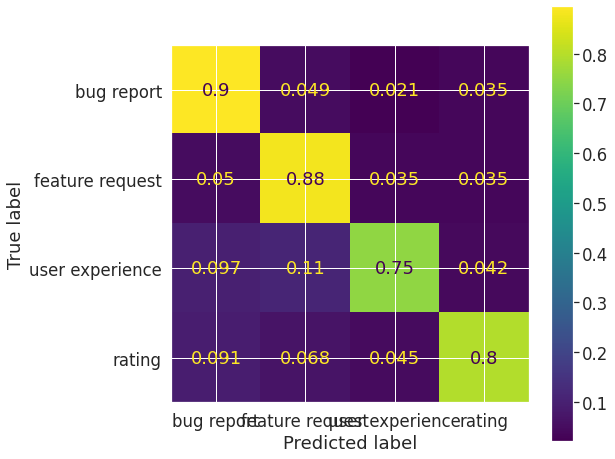

In [114]:
labels = {
    "bug report": 0,
    "feature request": 1,
    "rating": 2,
    "user experience": 3
        }

# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=flat_true_labels, y_pred=predictions_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)